In [48]:
#!pip install selenium
#!pip install monkeylearn
#!pip install nltk
#!pip install wordcloud
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
from bs4 import BeautifulSoup
import requests
from tqdm import tqdm
import pandas as pd
import numpy as np

import time
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from monkeylearn import MonkeyLearn
import matplotlib
import matplotlib.pyplot as plt

import re
import nltk


from sklearn.linear_model import LogisticRegression 


Загрузка необходимых библиотек

In [49]:
#!pip install webdriver-manager
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

driver = webdriver.Chrome(ChromeDriverManager().install())




====== WebDriver manager ======
Current google-chrome version is 91.0.4472
Get LATEST driver version for 91.0.4472
Driver [C:\Users\Andrew\.wdm\drivers\chromedriver\win32\91.0.4472.101\chromedriver.exe] found in cache


Установка драйвера chronium для автоматизации ПО для работы с получением данных с сайта.

In [50]:
base = "https://www.nytimes.com"
browser = webdriver.Chrome('.\chromedriver_win32\chromedriver.exe')
wait = WebDriverWait(browser, 3)
browser.get('https://www.nytimes.com/search?query=Russia')


Подключаемся через драйвер хрома к новостному сайту New York Times с запросом по новостям "Russia"

In [51]:
for i in range(30):
    try:
        time.sleep(2)  #задержка, чтобы сайт успел прогрузить посты
        show_more = wait.until(EC.element_to_be_clickable((By.XPATH,
        '//button[@type="button"][contains(.,"Show More")]')))
        show_more.click()
    except Exception as e:
            print(e)
            break


Прогружаем заголовки через автоматическое ПО (30 раз нажимает кнопку "Show More", пожгружая новые новостные посты)

In [52]:
soup = BeautifulSoup(browser.page_source, 'lxml')
search_results = soup.find_all('h4')
articles = []

articles = [None] * len(search_results)

i = 0
for h4 in search_results:
    tmp = []
    name = h4.text
    tmp.append(name)
    articles[i] = tmp
    i += 1
    

Через BeautifulSoup находим заголовки и сохраняем их в массив articles.

In [53]:
articles = articles[:300:]
print(len(articles))


300


api Monkeylearn предоставляет только 300 запросов в месяц на анализ текста, поэтому довольствуемся тем, что имеем(((
Если запускать код повторно то вылезет ошибка о привышенном лимите на monkeylearn. Если Необходимо проверить эту часть работы придется изменить api key, достаточно просто зарегистрироваться на monkeylearn.

In [54]:
#ml = MonkeyLearn('YOUR API KEY')
#model_id = 'cl_pi3C7JiL'
#data = [x[0] for x in articles]
#result = ml.classifiers.classify(model_id, data)
#print(result.body)


In [55]:
pos_cou = 0
netr_cou = 0
neg_cou = 0
class_arr = []

for i in result.body:
    if (i['classifications'][0]['tag_name'] == 'Positive'):
        pos_cou += 1
        class_arr.append(1)
    elif (i['classifications'][0]['tag_name'] == 'Negative'):
        neg_cou += 1
        class_arr.append(-1)
    else:
        netr_cou += 1
        class_arr.append(0)
print("Negative count:", neg_cou)
print("Positive count:", pos_cou)
print("Netural count:", netr_cou)


Negative count: 29
Positive count: 23
Netural count: 248


Визуализируем полученный результат.

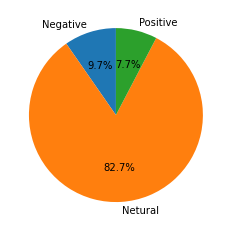

In [56]:
fig1, ax1 = plt.subplots()
sizes = []
sizes.append(neg_cou / 300 )
sizes.append(netr_cou / 300 )
sizes.append(pos_cou / 300 )
labels = ['Negative', 'Netural', 'Positive']
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
#ax1.axis('equal')

plt.show()


Попробуем написать свой классификатор с учителем. Для работы со словами будем использовать nltk библиотеку для анализа текста. Для анализа текста используем NLP(Natural Language Processing)


In [57]:
#print(articles)


Разобьем на классы следующим образом: 

-1 - Negative

 0 - Netural

1 - Possitive


In [58]:
data = [x[0] for x in articles]
table = pd.DataFrame({'Text': data, 'Class': class_arr})
print(table.head())


                                                Text  Class
0  McGahn Is Likely to Testify Next Week on Trump...      0
1  Judge Says Barr Misled on How His Justice Dept...      0
2  Attempted Hack of R.N.C. and Russian Ransomwar...     -1
3      Plane Crashes in Russia With 28 People Aboard     -1
4  Search Teams Identify Site of Russian Plane Crash     -1


In [59]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


stop_words = stopwords.words('english') # определяем стоп-слова 
stop_words.remove('not') # удаляем not для анализа отрицательных заголовков 
lemmatizer = WordNetLemmatizer()

def data_preprocessing(title):
    
  # data cleaning
  title = re.sub(re.compile('<.*?>'), '', title) #удаялем лишние символы 
  title =  re.sub('[^A-Za-z0-9]+', ' ', title) #выюираем слова 
  
  # приводим к нижнему регистру
  title = title.lower()
  
  # создаем токены слов 
  tokens = nltk.word_tokenize(title) # конвертируем в токен нашу строчку
  
  # stop_words removal
  title = [word for word in tokens
        if word not in stop_words] #проверка на стоп-слово
  
  # лематизация
  title = [lemmatizer.lemmatize(word) for word in title]
  
  # соединяем слова
  title = ' '.join(title)
  
  return title


In [60]:
table['preprocessed_review'] = table['Text'].apply(
    lambda title: data_preprocessing(title))


In [61]:
print(table.head())


                                                Text  Class  \
0  McGahn Is Likely to Testify Next Week on Trump...      0   
1  Judge Says Barr Misled on How His Justice Dept...      0   
2  Attempted Hack of R.N.C. and Russian Ransomwar...     -1   
3      Plane Crashes in Russia With 28 People Aboard     -1   
4  Search Teams Identify Site of Russian Plane Crash     -1   

                                 preprocessed_review  
0  mcgahn likely testify next week trump effort o...  
1  judge say barr misled justice dept viewed trum...  
2  attempted hack r n c russian ransomware attack...  
3                plane crash russia 28 people aboard  
4      search team identify site russian plane crash  


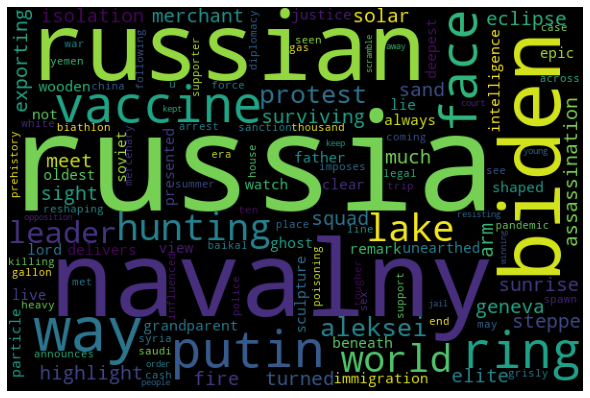

In [62]:
from wordcloud import WordCloud

#positive word cloud

words_list = table[table['Class'] == 1]['preprocessed_review'].unique().tolist()
pos_words = " ".join(words_list)

pos_wordcloud = WordCloud(
                  width=600, height=400,
                  stopwords=stop_words).generate(pos_words)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


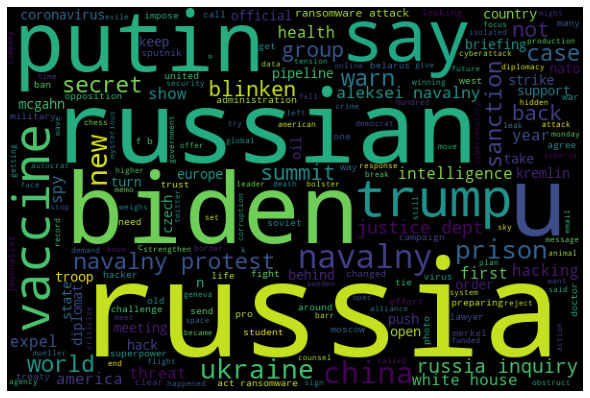

In [63]:
#netural word cloud

words_list = table[table['Class'] == 0]['preprocessed_review'].unique().tolist()
net_words = " ".join(words_list)

net_wordcloud =  WordCloud(
                  width=600, height = 400,
                  stopwords=stop_words).generate(net_words)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(net_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


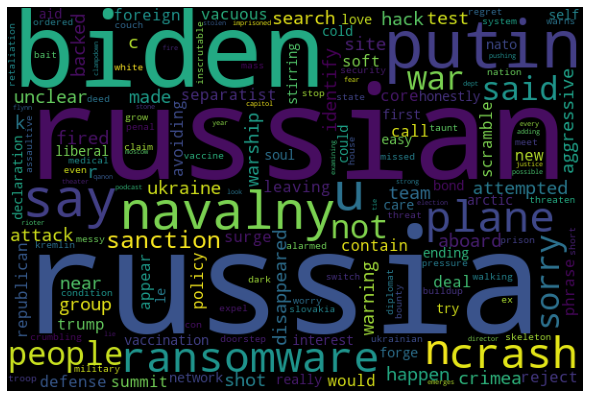

In [64]:
#negative word cloud

words_list = table[table['Class'] == -1]['preprocessed_review'].unique().tolist()
neg_words = " ".join(words_list)

neg_wordcloud =  WordCloud(
                  width=600, height = 400,
                  stopwords=stop_words).generate(neg_words)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(neg_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


In [65]:
from sklearn.model_selection import train_test_split

data = table.copy()
y = data['Class'].values
data.drop(['Class'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data,
                                                    y, test_size=0.3,
                                                    stratify=y)

print("Train:",  X_train.shape, y_train.shape)
print("Test:",  X_test.shape, y_test.shape)

Train: (210, 2) (210,)
Test: (90, 2) (90,)


Для анализа текста используем принцип tf-idf, где tf - частота вхождения слова в документ(насколько важно слово для получения класса), idf- обратная частота вхождения слова в другие документы. 

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.95)

X_train_review_tfidf = vectorizer.fit_transform(X_train['preprocessed_review'])
X_test_review_tfidf = vectorizer.transform(X_test['preprocessed_review'])

print('X_train_review_tfidf shape: ', X_train_review_tfidf.shape)
print('X_test_review_tfidf shape: ', X_test_review_tfidf.shape)


X_train_review_tfidf shape:  (210, 852)
X_test_review_tfidf shape:  (90, 852)


In [67]:
import warnings
warnings.filterwarnings('ignore')


In [68]:
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')


clf = LogisticRegression(penalty='l2')
clf.fit(X_train_review_tfidf, y_train)

y_pred = clf.predict(X_test_review_tfidf)
print('Доля правильных ответов: ', accuracy_score(y_test, y_pred))


Доля правильных ответов:  0.8222222222222222


Такое ощущение, что проверять модель бесмысленно, так как обучалась она на довольно маленьком количестве данных, плюс обучение происходило на новостных заголовках, что вряд ли даст номарльные результаты для обычных предложений.

Получили вроде рабочую модельку данных с довольном неплохим критерием качества.